# Predicting Energy Consumption of DAEWOO Steel Co. Ltd.

Raphael E. Gutierrez • July 8, 2022

## Abstract
The information gathered is from the DAEWOO Steel Co. Ltd in Gwangyang, South Korea. It produces several types of coils, steel plates, and iron plates. The information on electricity consumption is held in a cloud-based system. The information on energy consumption of the industry is stored on the website of the Korea Electric Power Corporation (pccs.kepco.go.kr), and the perspectives on daily, monthly, and annual data are calculated and shown. This analysis seeks to identify the variables that highly affect the industry energy consumption and to fit a linear model that minimizes errors to predict the energy consumption using the given data set. Linear Regression will be used in this estimation. Since the objective of the analysis and prediction is not time-series-related, date variable will be dropped.

## Attribute Information
- Date - dd/mm/yyyy hh:mm based on a 24 hour system
- Usage_kWh (response) - Industry energy consumption, Continuous, kWh
- Lagging_Current_Reactive.Power_kVarh - Lagging current reactive power, Continuous, kVarh
- Leading_Current_Reactive_Power_kVarh - Leading current reactive power, Continuous, kVarh
- CO2(tCO2) - Measure of carbon dioxide, Continuous, ppm
- Lagging_Current_Power_Factor - Lagging current power factor, Continuous, %
- Leading_Current_Power_Factor - Leading current power factor, Continuous, %
- NSM - Number of seconds from midnight, Continuous, S
- WeekStatus - Week status, Categorical, (Weekend (0) or a Weekday(1))
- Day_of_week - Day of week, Categorical, Sunday, Monday - Saturday
- Load_Type - Load type, Categorical, Light Load, Medium Load, Maximum Load

## Business Problem
This analysis seeks to answer the following questions:
1. What variables highly affect the industry energy consumption?
2. What are the coefficients needed for the prediction with a reasonable accuracy while considering other metrics?

# Preliminaries

In [1]:
import requests, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
CSV_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00618/Steel_industry_data.csv"
r = requests.get(CSV_URL, stream=True)

df_raw = pd.read_csv(io.BytesIO(r.content))

In [3]:
df_raw.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [4]:
df_raw.shape

(35040, 11)

In [5]:
df_raw.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [6]:
df_raw.columns = ["date", "usage", "lagging_curr_rp", "leading_curr_rp", 
                  "tco2", "lagging_curr_pf", "leading_curr_pf", "nsm", 
                  "week_status", "day_of_week", "load_type"]

In [7]:
df_raw.head()

,date,usage,lagging_curr_rp,leading_curr_rp,tco2,lagging_curr_pf,leading_curr_pf,nsm,week_status,day_of_week,load_type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


# Data Evaluation

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             35040 non-null  object 
 1   usage            35040 non-null  float64
 2   lagging_curr_rp  35040 non-null  float64
 3   leading_curr_rp  35040 non-null  float64
 4   tco2             35040 non-null  float64
 5   lagging_curr_pf  35040 non-null  float64
 6   leading_curr_pf  35040 non-null  float64
 7   nsm              35040 non-null  int64  
 8   week_status      35040 non-null  object 
 9   day_of_week      35040 non-null  object 
 10  load_type        35040 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 2.9+ MB


In [9]:
df_raw.isnull().sum()

date               0
usage              0
lagging_curr_rp    0
leading_curr_rp    0
tco2               0
lagging_curr_pf    0
leading_curr_pf    0
nsm                0
week_status        0
day_of_week        0
load_type          0
dtype: int64

In [10]:
df_raw["usage"].min()

0.0

In [11]:
df_raw["usage"].max()

157.18

# Exploratory Data Analysis

## Descriptive Statistics

In [12]:
df_raw.describe()

,usage,lagging_curr_rp,leading_curr_rp,tco2,lagging_curr_pf,leading_curr_pf,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


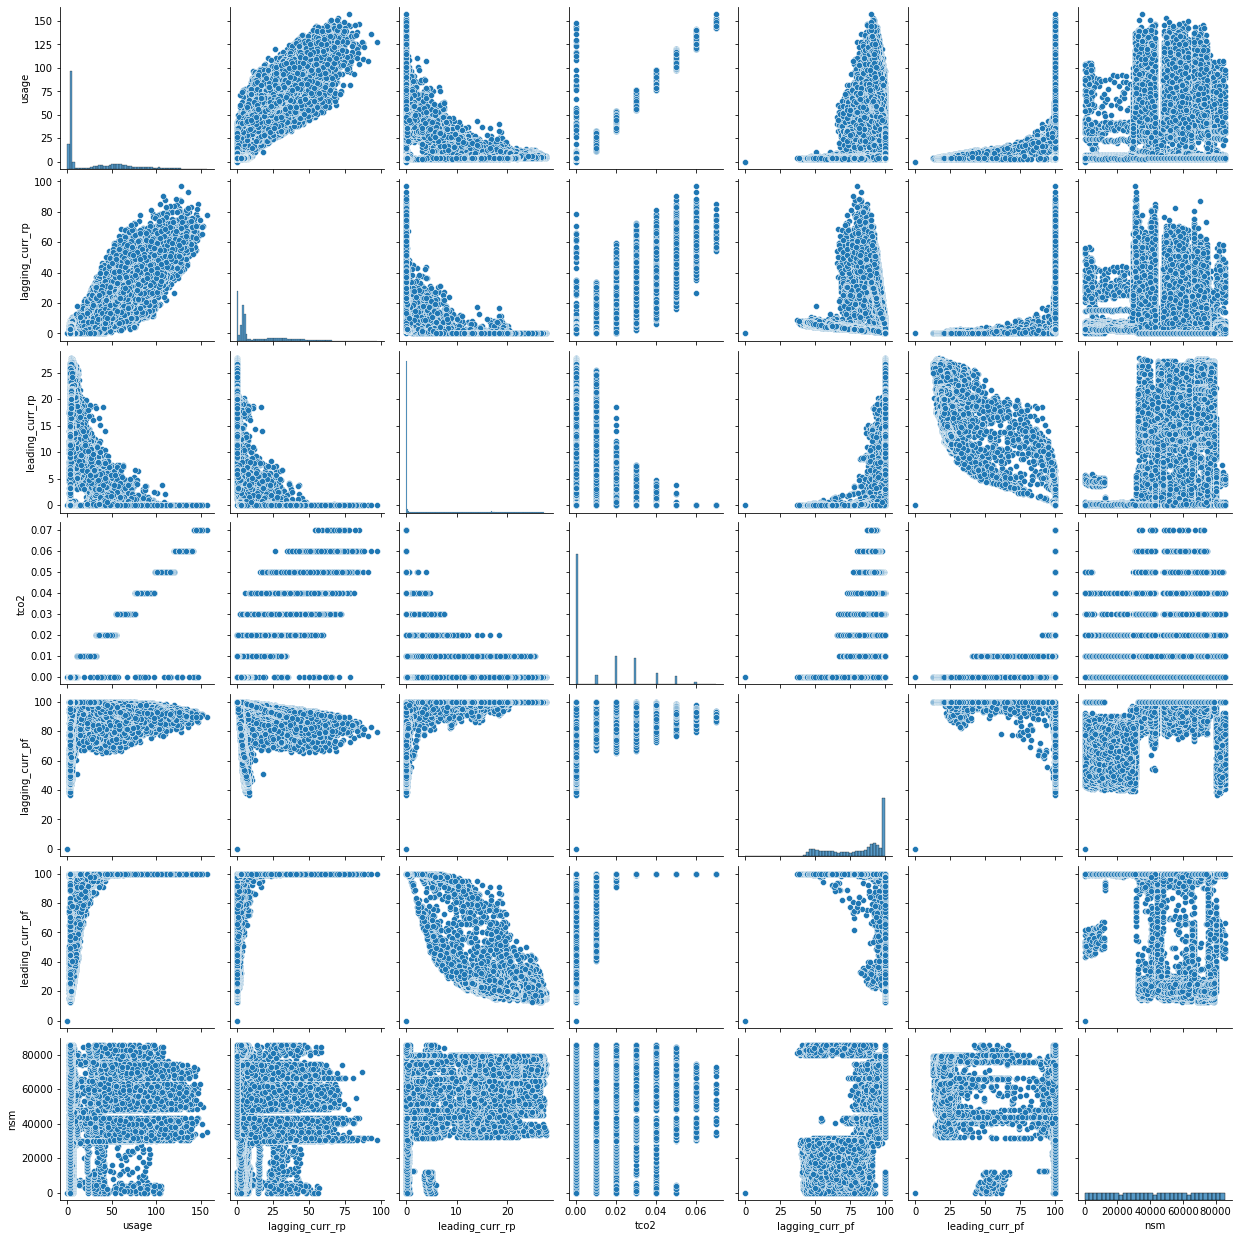

In [13]:
sns.pairplot(df_raw)

#pd.plotting.scatter_matrix(df_raw, alpha=0.2, figsize=(12, 10))
#plt.show()

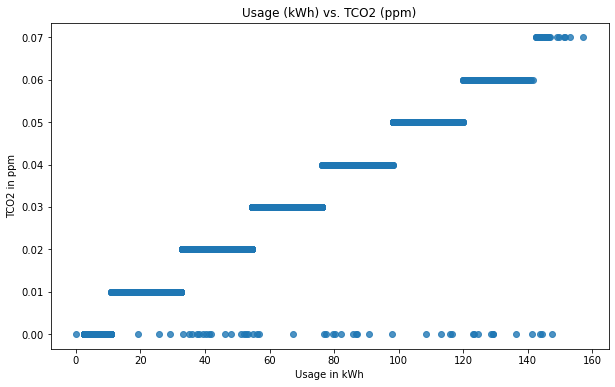

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(df_raw["usage"], df_raw["tco2"], alpha=0.8)
plt.xlabel("Usage in kWh")
plt.ylabel("TCO2 in ppm")
plt.title("Usage (kWh) vs. TCO2 (ppm)")
plt.show()

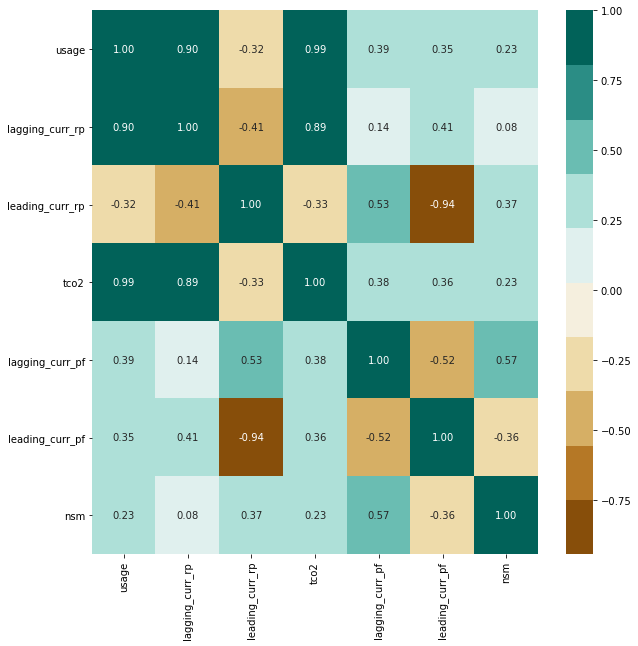

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_raw.corr(), cmap=colormap, annot=True, fmt=".2f")
plt.show()

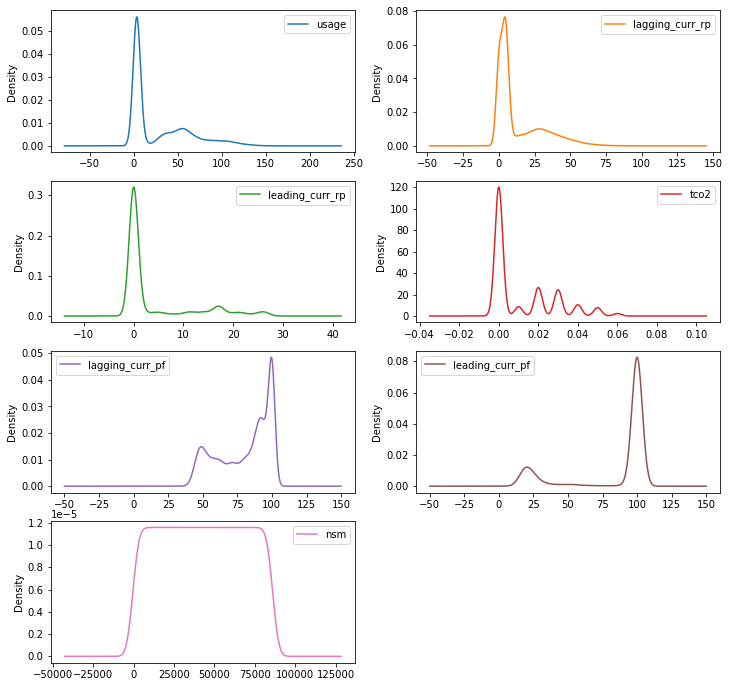

In [16]:
df_raw.plot(kind="density", subplots=True, layout=(4,2), figsize=(12,12), sharex=False)
plt.show()

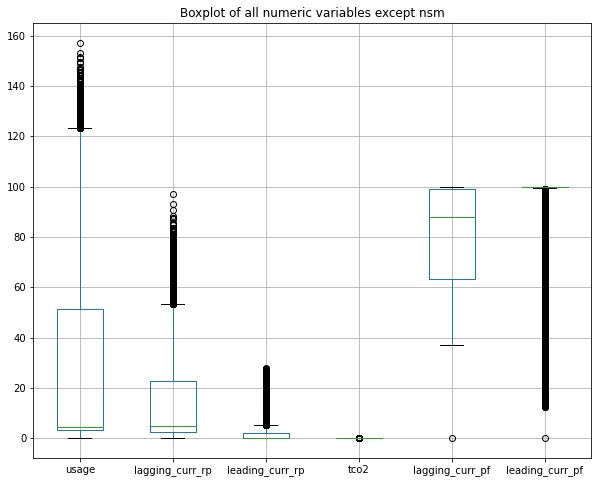

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
df_raw.loc[:, df_raw.columns != "nsm"].boxplot()
plt.title("Boxplot of all numeric variables except nsm")
plt.show()

## Looking at the response variable

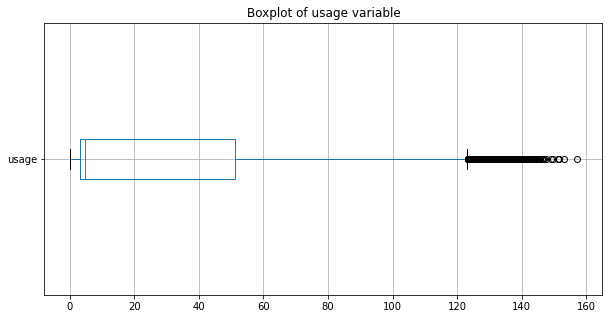

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
df_raw.boxplot("usage", vert=False)
plt.title("Boxplot of usage variable")
plt.show()

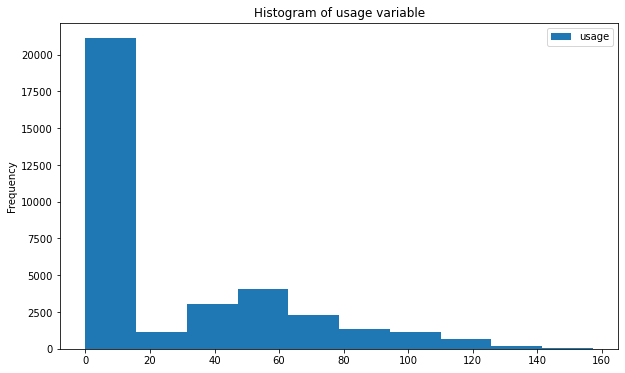

In [19]:
df_raw.plot(y="usage", kind="hist", figsize=(10, 6))
plt.title("Histogram of usage variable")
plt.show()

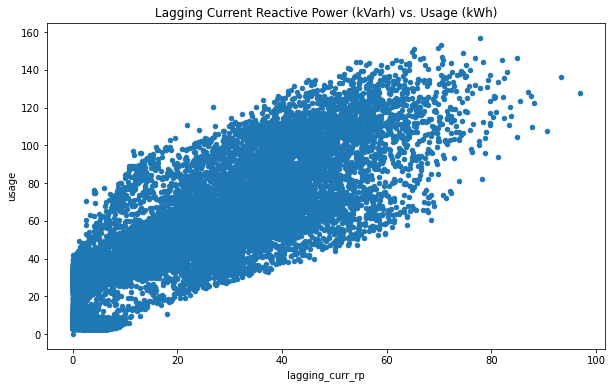

In [20]:
df_raw.plot(x="lagging_curr_rp", y="usage", kind="scatter", figsize=(10, 6))
plt.title("Lagging Current Reactive Power (kVarh) vs. Usage (kWh)")
plt.show()

## Notes

A couple of variables show relationship, whether positive or negative, to each other. For instance, at 0.90 correlation coefficient, the lagging current reactive power is positively correlated to usage (energy consumption). This relationship supports the assumption that when lagging current reactive power increases, an increase in usage is observed, or vice-versa. Another obsevation is that usage and tco2 variables are highly correlated at 0.99 correlation coefficient and lagging current reactive power and tco2 variables at 0.89 correlation coefficient. Meanwhile, leading current reactive power and leading current power factor are inversely correlated at -0.94. This means an increase made in one variable will result into a decrease of the other variable.

Some numerical variables have density plots that represent a huge distribution near 0. This is true to the response variable (usage). Meanwhile, the density plot of nsm variable can be explained since all instances of records per day are covered from 0 to 85500 seconds before midnight. Some fluctuations in distribution are also seen, possibly due to outliers or the nature of the data.

# Feature Engineering

In [21]:
df_raw.columns

Index(['date', 'usage', 'lagging_curr_rp', 'leading_curr_rp', 'tco2',
       'lagging_curr_pf', 'leading_curr_pf', 'nsm', 'week_status',
       'day_of_week', 'load_type'],
      dtype='object')

In [22]:
df_raw.describe()

,usage,lagging_curr_rp,leading_curr_rp,tco2,lagging_curr_pf,leading_curr_pf,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


## Feature Extraction & Selection

In [23]:
df = df_raw[["usage", "lagging_curr_rp", "leading_curr_rp", "lagging_curr_pf", "leading_curr_pf", "tco2", "week_status", "day_of_week", "load_type"]]

df.head()

,usage,lagging_curr_rp,leading_curr_rp,lagging_curr_pf,leading_curr_pf,tco2,week_status,day_of_week,load_type
0,3.17,2.95,0.0,73.21,100.0,0.0,Weekday,Monday,Light_Load
1,4.00,4.46,0.0,66.77,100.0,0.0,Weekday,Monday,Light_Load
2,3.24,3.28,0.0,70.28,100.0,0.0,Weekday,Monday,Light_Load
3,3.31,3.56,0.0,68.09,100.0,0.0,Weekday,Monday,Light_Load
4,3.82,4.50,0.0,64.72,100.0,0.0,Weekday,Monday,Light_Load


In [24]:
df["week_status"].value_counts()

Weekday    25056
Weekend     9984
Name: week_status, dtype: int64

In [25]:
week_status_map = {"Weekday": 0, "Weekend": 1}

df["week_status"] = df["week_status"].map(week_status_map)

df["week_status"].value_counts()

<ipython-input-25-1ae905320970>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["week_status"] = df["week_status"].map(week_status_map)


0    25056
1     9984
Name: week_status, dtype: int64

In [26]:
pd.get_dummies(df["day_of_week"])

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
35035,0,1,0,0,0,0,0
35036,0,1,0,0,0,0,0
35037,0,1,0,0,0,0,0
35038,0,1,0,0,0,0,0


In [27]:
onehot = pd.get_dummies(df["day_of_week"])
df = df.drop("day_of_week", axis=1)
df = df.join(onehot)

df.head()

,usage,lagging_curr_rp,leading_curr_rp,lagging_curr_pf,leading_curr_pf,tco2,week_status,load_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,3.17,2.95,0.0,73.21,100.0,0.0,0,Light_Load,0,1,0,0,0,0,0
1,4.00,4.46,0.0,66.77,100.0,0.0,0,Light_Load,0,1,0,0,0,0,0
2,3.24,3.28,0.0,70.28,100.0,0.0,0,Light_Load,0,1,0,0,0,0,0
3,3.31,3.56,0.0,68.09,100.0,0.0,0,Light_Load,0,1,0,0,0,0,0
4,3.82,4.50,0.0,64.72,100.0,0.0,0,Light_Load,0,1,0,0,0,0,0


In [28]:
df["load_type"].value_counts()

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: load_type, dtype: int64

In [29]:
week_status_map = {"Light_Load": 0, "Medium_Load": 1, "Maximum_Load": 2}

df["load_type"] = df["load_type"].map(week_status_map)

df["load_type"].value_counts()

0    18072
1     9696
2     7272
Name: load_type, dtype: int64

In [30]:
df.head()

,usage,lagging_curr_rp,leading_curr_rp,lagging_curr_pf,leading_curr_pf,tco2,week_status,load_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,3.17,2.95,0.0,73.21,100.0,0.0,0,0,0,1,0,0,0,0,0
1,4.00,4.46,0.0,66.77,100.0,0.0,0,0,0,1,0,0,0,0,0
2,3.24,3.28,0.0,70.28,100.0,0.0,0,0,0,1,0,0,0,0,0
3,3.31,3.56,0.0,68.09,100.0,0.0,0,0,0,1,0,0,0,0,0
4,3.82,4.50,0.0,64.72,100.0,0.0,0,0,0,1,0,0,0,0,0


# Model Training & Evaluation

## Splitting data set & model fitting

In [31]:
X = df.drop("usage", axis=1)
y = df["usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [32]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (28032, 14)
y_train: (28032,)
X_test: (7008, 14)
y_test: (7008,)


In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = model.predict(X_test)

model.score(X_test, y_test)

0.9842419962395764

## Results

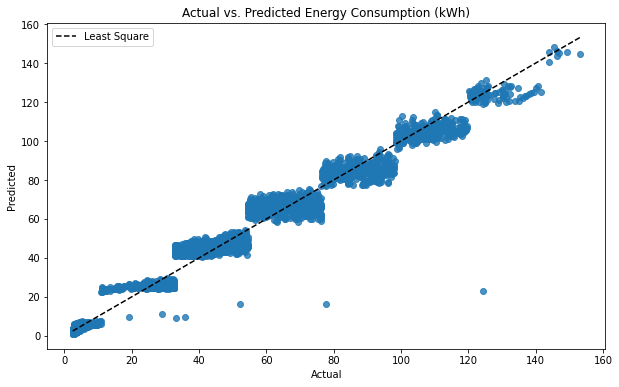

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", label="Least Square")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Actual vs. Predicted Energy Consumption (kWh)")
plt.show()

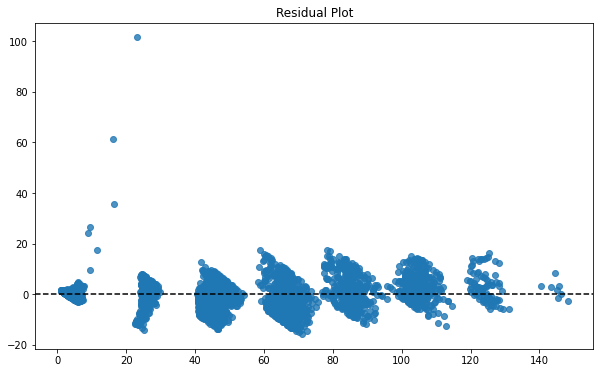

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(y_pred, y_test-y_pred, alpha=0.8)
plt.axhline(y=0, c="black", linestyle="--", label="Least Square")
plt.title("Residual Plot")
plt.show()

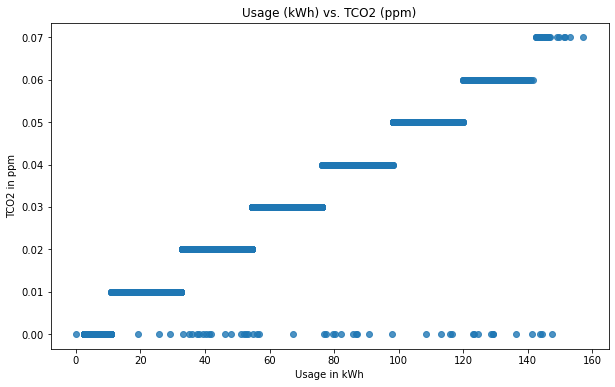

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(df_raw["usage"], df_raw["tco2"], alpha=0.8)
plt.xlabel("Usage in kWh")
plt.ylabel("TCO2 in ppm")
plt.title("Usage (kWh) vs. TCO2 (ppm)")
plt.show()

In [38]:
model.coef_

array([ 3.18074898e-01,  1.12098164e-01,  1.26918789e-01,  6.76858107e-02,
        1.65741491e+03, -9.35389542e-02,  5.83584078e-01, -1.30108592e-01,
       -1.15737123e-01, -1.19781676e-01,  2.62427215e-02, -1.90138222e-01,
        5.93260377e-01, -6.37374870e-02])

In [39]:
x_ols = sm.add_constant(X_train)

model = sm.OLS(y_train, x_ols)
results = model.fit()

results.params

const               -10.697974
lagging_curr_rp       0.318075
leading_curr_rp       0.112098
lagging_curr_pf       0.126919
leading_curr_pf       0.067686
tco2               1657.414908
week_status          -1.352124
load_type             0.583584
Friday               -2.017986
Monday               -2.003615
Saturday             -0.749074
Sunday               -0.603050
Thursday             -2.078016
Tuesday              -1.294617
Wednesday            -1.951615
dtype: float64

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  usage   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.103e+05
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:24:06   Log-Likelihood:                -83776.
No. Observations:               28032   AIC:                         1.676e+05
Df Residuals:                   28019   BIC:                         1.677e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -10.6980      0.372    -28.736      0.000     -11.428      -9.968
lagging_curr_rp     0.3181      0.004     71.299      0.000       0.309       0.327
leading_curr_rp     0.1121      0.012      9.051      0.000       0.088       0.136
lagging_curr_pf     0.1269      0.003     42.139      0.000       0.121       0.133
leading_curr_pf     0.0677      0.003     20.861      0.000       0.061       0.074
tco2             1657.4149      5.604    295.766      0.000    1646.431    1668.399
week_status        -1.3521      0.055    -24.696      0.000      -1.459      -1.245
load_type           0.5836      0.052     11.166      0.000       0.481       0.686
Friday             -2.0180      0.096    -20.991      0.000      -2.206      -1.830
Monday             -2.0036      0.095    -21.143      0.000      -2.189      -1.818
Saturday           -0.7491      0.061    -12.198      0.000      -0.869      -0.629
Sunday             -0.6030      0.061     -9.947      0.000      -0.722      -0.484
Thursday           -2.0780      0.097    -21.448      0.000      -2.268      -1.888
Tuesday            -1.2946      0.096    -13.441      0.000      -1.483      -1.106
Wednesday          -1.9516      0.095    -20.564      0.000      -2.138      -1.766
==============================================================================
Omnibus:                    34404.774   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18821583.729
Skew:                           6.132   Prob(JB):                         0.00
Kurtosis:                     129.349   Cond. No.                     1.99e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  1e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Notes

Initial model fitting produces a 0.984 adjusted R-squared (Adj. R-squared is used because of its ability to make a more accurate view of the correlation between one variable and another). Using statsmodel, a 0.979 adjusted R-squared is produced which is a very high value, somewhat doubting. F-statistic is also very large enough to support the relationship between the response and predictor variables (rejecting null hypothesis, if there's any). Variable tco2 highly affects the fitted model with a coefficient of 1657.4149 and 295.766 t-value, yet having a standard error of 5.604. The actual vs. predicted usage plot and the scatter plot of tco2 in y-axis are highly identical, assuming a very strong relationship. This will be handled in tuning the model. Statsmodel also identifies a strong multicollinearity problem or that the design matrix is singular.

# Model Tuning

In [41]:
df2 = df[["usage", "lagging_curr_rp", "leading_curr_rp", "lagging_curr_pf", "leading_curr_pf", "tco2", "week_status", "load_type"]]

X2 = df2.drop("usage", axis=1)
y2 = df2["usage"]

X_train, X_test, y_train, y_test = train_test_split(X2, y2, train_size=0.8, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (28032, 7)
y_train: (28032,)
X_test: (7008, 7)
y_test: (7008,)


In [42]:
x_ols2 = sm.add_constant(X_train)

model2 = sm.OLS(y_train, x_ols2)
results2 = model2.fit()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  usage   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.886e+05
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:24:24   Log-Likelihood:                -83813.
No. Observations:               28032   AIC:                         1.676e+05
Df Residuals:                   28024   BIC:                         1.677e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -12.5455      0.439    -28.600      0.000     -13.405     -11.686
lagging_curr_rp     0.3185      0.004     71.319      0.000       0.310       0.327
leading_curr_rp     0.1100      0.012      8.898      0.000       0.086       0.134
lagging_curr_pf     0.1274      0.003     42.240      0.000       0.121       0.133
leading_curr_pf     0.0672      0.003     20.795      0.000       0.061       0.074
tco2             1656.8749      5.610    295.367      0.000    1645.880    1667.870
week_status        -0.1647      0.069     -2.370      0.018      -0.301      -0.028
load_type           0.5747      0.052     11.024      0.000       0.473       0.677
==============================================================================
Omnibus:                    34688.828   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19477388.843
Skew:                           6.223   Prob(JB):                         0.00
Kurtosis:                     131.534   Cond. No.                     2.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

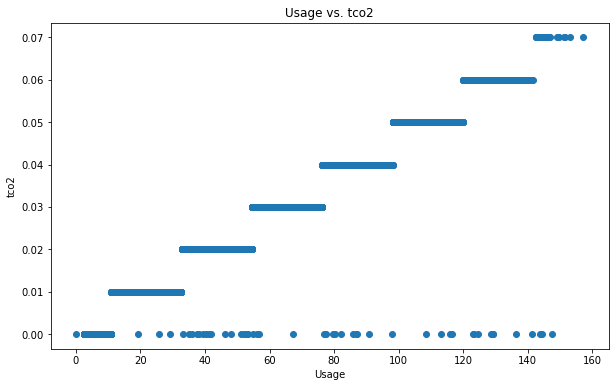

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df["usage"], df["tco2"])
plt.xlabel("Usage")
plt.ylabel("tco2")
plt.title("Usage vs. tco2")
plt.show()

In [44]:
df3 = df[["usage", "lagging_curr_rp", "leading_curr_rp", "week_status", "load_type"]]

X3 = df3.drop("usage", axis=1)
y3 = df3["usage"]

X_train, X_test, y_train, y_test = train_test_split(X3, y3, train_size=0.8, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (28032, 4)
y_train: (28032,)
X_test: (7008, 4)
y_test: (7008,)


In [45]:
x_ols3 = sm.add_constant(X_train)

model3 = sm.OLS(y_train, x_ols3)
results3 = model3.fit()

results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  usage   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 4.283e+04
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:24:33   Log-Likelihood:            -1.1061e+05
No. Observations:               28032   AIC:                         2.212e+05
Df Residuals:                   28027   BIC:                         2.213e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9987      0.137     -7.306      0.000      -1.267      -0.731
lagging_curr_rp     1.5852      0.006    270.006      0.000       1.574       1.597
leading_curr_rp    -0.0619      0.011     -5.406      0.000      -0.084      -0.039
week_status         0.6244      0.178      3.517      0.000       0.276       0.972
load_type          11.2550      0.109    102.886      0.000      11.041      11.469
==============================================================================
Omnibus:                     5063.870   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16091.660
Skew:                           0.926   Prob(JB):                         0.00
Kurtosis:                       6.217   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Notes

In the tuned model, it is identified that variable tco2 is causing the condition number to be large. It is assumed that outliers are causing this problem. However through identifying outliers by calculating interquartile range, the resulting data set is not enough to make a strong prediction. Also, handling few outliers in tco2 only affects the model minimally so removing the variable is the reasonable compromise. For the remaining variables, removing the lagging and leading power factors and the days of the week helps the model to perform better and produce greater metric evaluations. With 0.859 adjusted R-squared, 4.283e+04 f-statistic, and below 0.05 of p-values per variables, the final model is chosen.

# Final Model

In [46]:
model_final = LinearRegression()
model_final.fit(X_train, y_train)

LinearRegression()

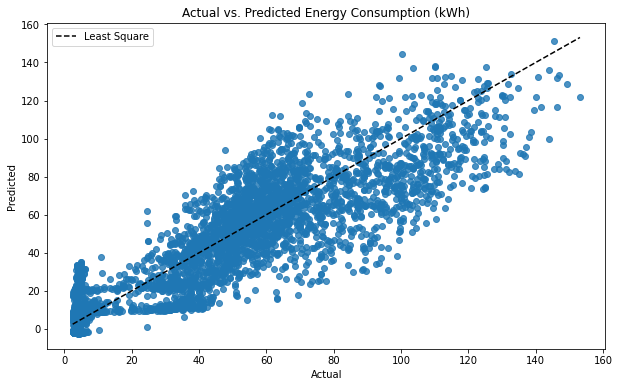

In [47]:
y_pred = model_final.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", label="Least Square")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Actual vs. Predicted Energy Consumption (kWh)")
plt.show()

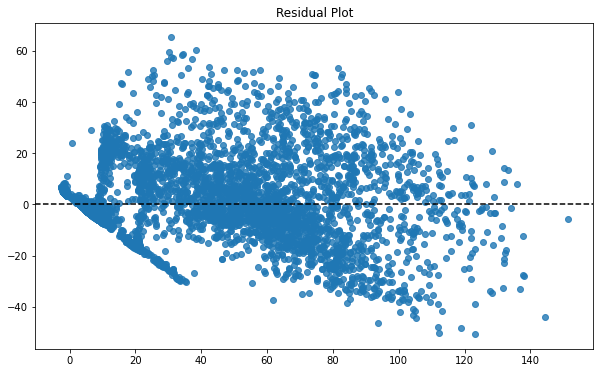

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(y_pred, y_test-y_pred, alpha=0.8)
plt.axhline(y=0, c="black", linestyle="--", label="Least Square")
plt.title("Residual Plot")
plt.show()

# Conclusion

### Variables that highly affect the industry energy consumption

While the amount of carbon dioxide (tco2) is not a predictor in the linear model, correlation matrix in the heatmap shows tco2 is highly correlated to industry energy consumption (usage) at 0.99 correlation coefficient. Next is the lagging current reactive power at 0.90. For both variables, this means an increase made in one variable will result into an increase of the other variable. A decrease in one results to decrease of the other.


### Coefficients needed for the prediction with a reasonable accuracy while considering other metrics

In the final model, variables lagging current reactive power, leading current reactive power, week status (label encoded), and load type (label encoded) are used as predictors to predict the response variable which is usage (energy consumption). The following values below will result into an adjusted R-squared of 0.859 with standard error < 0.179:

| Variable                       | Coefficient |   |   |   |
|--------------------------------|---------|---|---|---|
| Intercept                      | -0.9987 |   |   |   |
| lagging current reactive power | 1.5852  |   |   |   |
| leading current reactive power | -0.0619 |   |   |   |
| week status                    | 0.6244  |   |   |   |
| load type                      | 11.2550 |   |   |   |

Final equation will be:
$$Y=-0.9987 + 1.5852X_1 - 0.0619X_2 + 0.6244X_3 + 11.2550X_4$$

*Note: Adjusted R-squared is used because of its ability to make a more accurate view of the correlation between one variable and another, suitable for multiple linear regression*


## Other observations
- Some numerical variables have density plots that represent a huge distribution near 0
- Variable tco2 highly affects the fitted model with a coefficient of 1657.4149 and 295.766 t-value, yet having a standard error of 5.604
- Some fluctuations in distribution are seen, possibly due to outliers or the nature of the data
- F-statistic is very large enough to support the relationship between the response and predictor variables (rejecting null hypothesis, if there's any)
- p-values per variables are below 0.05 significance level (rejecting null hypothesis, if there's any)
- Therefore, there is much less than 5% chance that the f-statistic of 4.283e+04 could have occurred by chance under the assumption of a valid null hypothesis
- The chance of seeing this data under the assumption of a null hypothesis (no relationship between predictors and response variables) is less than 0.00 (P>|t|) which is very unlikely 

## Recommendations

Since the model performs well and produces good metric values, it is recommended to use the model for the energy consumption prediction for the steel industry, DAEWOO Steel Co. Ltd. of South Korea. However, additional recommendations based on the analysis shall be considered:
- Due to limited time, some important uncovered variables are not examined thoroughly
- Since the owner is still learning, improvement in coding structure, data analysis, interpretation, and documentation are matters needed to enhance
- Future notebook can be split into multiple notebooks for organization and readability purposes (eg. one for data preparation and another one for modeling)
- The owner is open for comments and other recommendations to improve his work

## References
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.